# COS 463 Wireless Networks - Spring 2018
# Lab 1: Building a Spectrum Analyzer using HackRF

In this lab we will be exploring the discrete Fourier transform which is one of the most important concepts in radio signal processing. We will also be working with real radio hardware to record radio signals and to understand some of the quirks of radio hardware. Finally, we'll implement a simple spectrograph which is a tool that's commonly used to visualize signals in both frequency and time.

Beyond introducing these three concepts, the goal of this lab is to develop an understanding of the lowest "layer" of wireless communication - the "physical" layer. By the end of this lab, you should be able to answer:

-  What is a radio "signal"? How is a radio signal represented in the digital domain?
-  What is the wireless "spectrum"?
-  What does it mean for a signal to have high bandwidth?

In [1]:
%matplotlib notebook

import math

from IPython.display import HTML
from matplotlib import animation, pyplot, rc
import numpy
import SoapySDR
from SoapySDR import SOAPY_SDR_RX, SOAPY_SDR_CF32

# Part 0: The Discrete Fourier Transform

Consider the equation for the DFT of a signal $x$ of length $N$
$$\Large X[k] = \sum_{n=0}^{N-1} x[n] e^{-i 2 \pi \frac{k n}{N}}$$
In the above equation, $X$ is also length $N$ and the value at index $k$ is the frequency component of $x$ at normalized frequency $2\pi \frac{k}{N}$ radians per sample. Each element of $X$ is the result of multiplying the signal $x$ by a tone (a signal with only one frequency component) at the appropriate frequency, then summing the result. It's remarkable that the DFT is invertible; to go from $X$ to $x$ simply apply the same transformation except with a positive exponential instead of the negative. This is the "Inverse Discrete Fourier Transform" (IDFT).

### Problem 0.1 Implementing the DFT (10 pts)
- _Implement the DFT on your own using the above equation (let $k$ range from 0 to $N - 1$). Compare against numpy's version on a random signal. Use the below cell for your code and testing._

In [2]:
def dft(signal):
    """
    The input is a complex signal, and the output is a complex signal of the same length
    """
    # Implement this function
    return signal

# random complex sequence
signal = numpy.random.random(10) + 1j * numpy.random.random(10)
# Assert that your code matches numpy's version of the DFT
#numpy.testing.assert_almost_equal(dft(signal), numpy.fft.fft(signal))

The DFT measures the frequency components of a time-domain signal at frequencies equally spaced between $0$ and $2 \pi$ radians per sample (note the units, which may be unfamiliar). If a signal is sampled with bandwidth $B$ Hz, then the DFT will return frequencies between $0$ and $B$ Hz, or equivalently, between $-B/2$ and $B/2$ (positive frequencies above $B/2$ are aliased to negative frequencies. You can read more about this phenomenon [here](https://en.wikipedia.org/wiki/Aliasing)).

So the signal bandwidth (time resolution) determines the spectrum frequency range. It so happens that the "dual" relationship is also true: The signal duration determines the spectrum frequency resolution.

### Problem 0.2 Understanding Frequency (10 pts)
Consider the signal given below which consists of one frequency. If you take the DFT of this signal, the frequency will be between two bins.

<IPython.core.display.Javascript object>


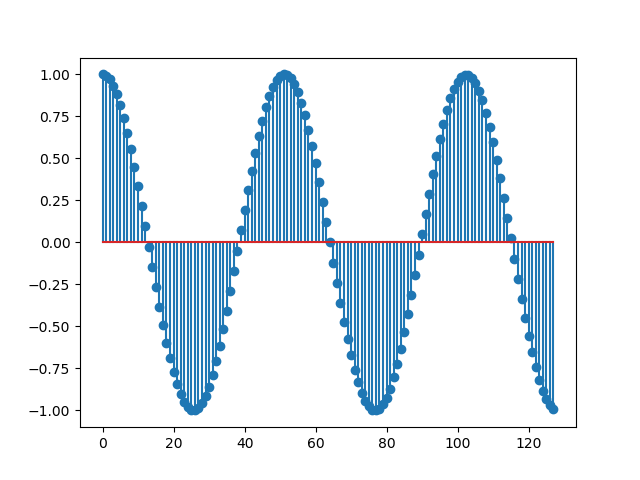

In [3]:
signal = numpy.exp(1j * 2 * numpy.pi * (2.5 / 128) * numpy.arange(128))

pyplot.figure(); pyplot.stem(signal.real); pyplot.show()

#### a) (4 pts)
- _Plot the DFT of this signal (the DFT is complex, just plot the magnitudes)_

#### b) (4 pts)
- _Double the length of the signal by adding zeros to the end of the signal. Plot the DFT of this "zero-padded" signal in a separate plot_

#### c) (2 pts)
- _The zero-padded DFT has twice as many points as the original. Which frequencies $k$ in the zero-padded DFT are the same as those in the DFT of the original signal?_
You can use either your implementation of the DFT or `numpy`'s.

What could you do if you wanted the component of an arbitrary frequency? One option is to zero-pad the signal until the chosen frequency shows up in the discrete spectrum, but this can be inefficent for some frequencies.
### Problem 0.3 Fine Frequency Adjustments (10 pts)
-  _Write a python function that calculates the frequency "bin" for an arbitrary frequency on a signal. Your function should pass all of the test cases below._

Your function `get_freq_component` should take a signal which is an array of complex values and a frequency index $k$ which will be a floating point number, and it should return a complex value.
Hint: consider what would happen if the value of $k$ in the definition of the DFT is not an integer.

In [8]:
def get_freq_component(signal, k):
    pass
#numpy.testing.assert_almost_equal(get_freq_component(signal, 0.123), 6.8347 + 14.3405j, decimal=4)
#numpy.testing.assert_almost_equal(get_freq_component(signal, 0.555), -3.5157 + 0.7881j, decimal=4)
#numpy.testing.assert_almost_equal(get_freq_component(signal, 0.999), 0.9148 + 27.1349j, decimal=4)

### Problem 0.4 Low-Pass Filtering with the DFT (10 pts)

Now, we will implement a low-pass filter using the DFT. A low-pass filter is a filter that takes a signal and removes (or significantly attenuates) the high frequencies, leaving behind the lower frequency components. Below is an example of a low-passed signal.

<IPython.core.display.Javascript object>


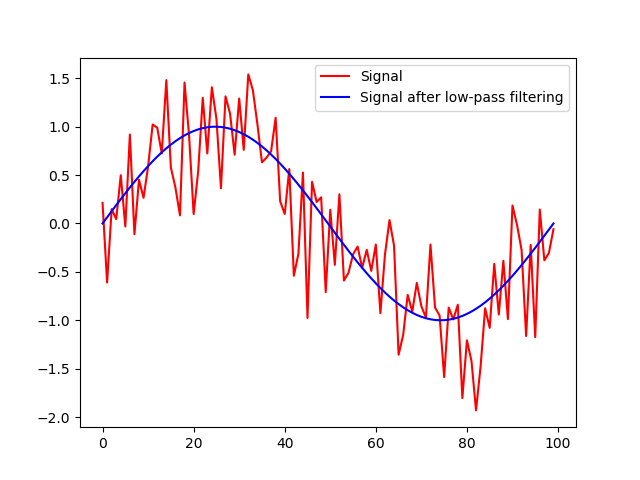

In [30]:
x = numpy.linspace(0, 2 * numpy.pi, 100)
lpf_signal = numpy.sin(x)
signal = lpf_signal + numpy.random.normal(size=len(lpf_signal), scale=0.5)

pyplot.figure()
pyplot.plot(signal, 'red', label='Signal')
pyplot.plot(lpf_signal, 'blue', label='Signal after low-pass filtering')
pyplot.legend()
pyplot.show()

Consider the random signal below. Take the DFT of this signal, then zero-out the higher half of the frequencies. The high frequencies are considered those greater than $B/4$ and less than $-B/4$ (we want to remove large negative frequencies as well). Be careful to remove the right frequencies. Then use the inverse DFT to recover the filtered time-domain signal.

- _Plot the original signal and the signal after the low-pass filter (you can plot just the real component of both signals)_.

Note that in practice, this isn't a great low-pass filter. You can read more [here](https://dsp.stackexchange.com/questions/6220/why-is-it-a-bad-idea-to-filter-by-zeroing-out-fft-bins) if you're curious why this approach is suboptimal.

In [5]:
signal_len = 64
signal = numpy.random.random(signal_len) + 1j * numpy.random.random(signal_len)

# Part 1: Interfacing with the HackRF radio

The [HackRF](https://github.com/mossmann/hackrf/wiki/HackRF-One) is a low-cost software-defined radio (SDR). We use the term "software-defined" to distinguish from the more typical hardware radios found in things like cell phones where radio parameters like center frequency, sample rate (bandwidth), gain, and analog filters are all set in hardware. For SDRs, these parameters can vary over a wide range and can be set in software. So SDRs are more flexible than typical radio hardware, but they are more expensive and draw more power.

Nearly all modern digital radios (software-defined or not) will deal with complex digital samples. These samples are sometimes called "in-phase and quadrature" samples or simply I/Q samples ("in-phase" refers to the real part and "quadrature" refers to the imaginary part). The reason for using complex values has to do with hardware design which we won't go into in this course, but it is also mathematically convenient (consider the definition of the DFT uses complex values).

### Problem 1.1 Tuning in on the airwaves (10 pts):
- _Using the API below, tune your HackRF hardware to a center frequency of 1250MHz at a bandwidth of 5MHz and capture 1M samples. Plot the samples in the time domain and the frequency domain (i.e. after applying the DFT)._

Plot the real and imaginary components of the time signal separately (on the same plot), and plot the magnitude of the spectrum (with a logarithmic scale).

Use the `Radio` class provided below. Software radios usually do buffered I/O, meaning samples are buffered in the radio hardware and then the whole buffer is sent to the computer. This is instead of sending one sample at a time to the computer, which would be inefficient. So you'll need to grab samples in chunks of the buffer size and store them in memory. The buffer size for the HackRF is 131072 samples, and is set in hardware so it cannot be changed. You may grab samples from the HackRF in chunk sizes up to and including the buffer size.

In [7]:
class Radio:
    def __init__(self, *args, **kwargs):
        self.sdr = SoapySDR.Device(*args, **kwargs)

    def set_sample_rate(self, sample_rate_hz):
        self.sdr.setSampleRate(SOAPY_SDR_RX, 0, sample_rate_hz)

    def set_center_frequency(self, freq_hz):
        self.sdr.setFrequency(SOAPY_SDR_RX, 0, freq_hz)

    def start_receive(self):
        self.rx_stream = self.sdr.setupStream(SOAPY_SDR_RX, SOAPY_SDR_CF32)
        self.sdr.activateStream(self.rx_stream)

    def stop_receive(self):
        self.sdr.deactivateStream(self.rx_stream)
        self.sdr.closeStream(self.rx_stream)
        self.rx_stream = None

    def grab_samples(self, rx_buff):
        if self.rx_stream is None:
            raise RuntimeError("Need to start receiving before grabbing samples")

        if len(rx_buff) > self.get_buffer_size():
            raise RuntimeError("Number of samples cannot be more than the buffer size")

        resp = self.sdr.readStream(self.rx_stream, [rx_buff], numElems=len(rx_buff))
        if resp.ret != len(rx_buff):
            raise RuntimeError('Receive failed: {}'.format(SoapySDR.errToStr(resp.ret)))

    def get_buffer_size(self):
        return 131072

You should notice a signal centered at 1252 MHz with bandwidth 1 MHz. This is a real signal, i.e. it reflects the content of the wireless medium. But you should also notice in the spectrum a large magnitude at frequency 0. This is an artifact of the radio hardware (i.e. it's not a real signal in the wireless medium), and it's called the "DC offset." DC offset is very difficult to remove from the hardware, and so most practical radios simply deal with it, usually by not sending any data close to the center frequency and removing the DC offset in software.

One way to remove the DC offset from the recorded data is to just zero out the zero-frequency bin of the spectrum. But this requires taking an FFT of the data. How could you remove the DC offset from a recorded signal directly in the time domain? Hint: What does the zero frequency represent? Look at the definition of the DFT when $k = 0$.
### Problem 1.2 Removing the DC offset (10 pts)
- _Perform this operation to remove the DC offset from your received signal and plot the time signal and the spectrum just like in Problem 1.1._

# Part 2: Fine-tuning Your Reception

Both transmitters and receivers can have different **gains**. A transmitter's gain determines how loud the signal is over-the-air, and a receiver's gain determines how much a signal is amplified before being digitally sampled. The receive gain is important to get right because it determines the **dynamic range** of the analog-to-digital converter (ADC). For example, an 8-bit ADC has values between 0 and 255. The dynamic range is the voltage difference between the value of 0 and the value of 255. If the receive gain is too low, then the signal may be lost in the noise, but if the receive gain is too high, then all of your signal will have value close to 255 which will cause distortion. This distortion is known as "clipping," and is demonstrated below.

<IPython.core.display.Javascript object>


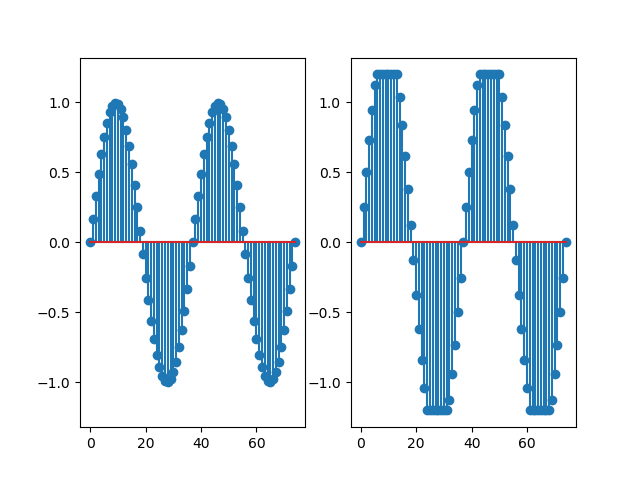

In [28]:
# Simulated example of the clipping effect
x = numpy.linspace(0, 4 * numpy.pi, 75)
normal_sine = numpy.sin(x)
high_gain_sine = 1.5 * normal_sine
pyplot.figure()
ax1 = pyplot.subplot(1, 2, 1)
pyplot.stem(numpy.clip(normal_sine, -1.2, 1.2))
pyplot.subplot(1, 2, 2, sharey=ax1)
pyplot.stem(numpy.clip(high_gain_sine, -1.2, 1.2))
pyplot.show()

Because receive gain is so important to the integrity of the signal, most radios use **automatic gain control**. When you received the previous signal, the hardware selected the appropriate gain setting automatically. Sometimes, you may want to override the automatic gain control and set the gain yourself.

### Problem 1.3 The Clipping Effect (10 pts)
Now tune the radio to 1260 MHz. Use the function below to set the radio's gain to the maximum value. Record once with the default gain settings, then again with the maximum settings.

In [37]:
def set_gain(radio, maximum):
    radio.sdr.setGainMode(SoapySDR.SOAPY_SDR_RX, 0, automatic=False)
    for gain in radio.sdr.listGains(SoapySDR.SOAPY_SDR_RX, 0):
        gain_range = radio.sdr.getGainRange(SoapySDR.SOAPY_SDR_RX, 0, gain)
        print(f'RX {gain}: {gain_range}')
        radio.sdr.setGain(SoapySDR.SOAPY_SDR_RX, 0, gain, gain_range.maximum() if maximum else gain_range.minimum())
    from time import sleep
    sleep(1)

#### a (7 pts)
- _Plot the I/Q time data and the spectrum magnitude for both signals._

#### b (3 pts)
- _Describe what happens to the spectrum when clipping occurs._

# Part 2: Spectrum Analyzer (optional)

### Problem 2 (10 bonus pts): Building a Simple Spectrograph

In this part you'll create a spectrogram, which is a three-dimensional plot of signal amplitude versus time and frequency. A spectrogram is created by taking chunks of a signal, performing a DFT on each chunk, and then plotting the resulting series of spectra versus time.

Consider the signal below.

In [11]:
num_samples = 100000
chirp = numpy.exp(1j * 2 * numpy.pi * numpy.linspace(0, 1, num_samples) * numpy.arange(num_samples))

#### a (15 pts)
- _Create two spectrograms, one where the chunk size is 1k and the other where the chunk size is 5k._

When creating a spectrogram, there is a tradeoff between time resolution and frequency resolution.
#### b (5 pts)
- _Which spectrogram has better frequency resolution, and what is the frequency resolution of both spectrograms?_

Be sure to correctly label the axes in both plots. You may use the [`specgram`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.specgram.html) function for inspiration, but you'll need to create the plots yourself.